In [29]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda

def ideal_neighbors(count):
    neighbors = []
    a = 0.564
    a1 = a*np.array([0, 0.5, 0.5])
    a2 = a*np.array([0.5, 0, 0.5])
    a3 = a*np.array([0.5, 0.5, 0])
    prim = np.array([a1, a2, a3])
    search_range = range(-2, 2)
    for i in search_range:
        for j in search_range:
            for k in search_range:
                if not (i == 0 and j == 0 and k == 0):
                    R = i*a1 + j*a2 + k*a3
                    neighbors.append(R)

    displacements = np.array(neighbors)

    norms = np.linalg.norm(displacements, axis = 1)
    idx = np.argsort(norms)
    return displacements[idx][:count]

def actual_neighbors(target, positions, count):
    displacements = positions - target
    norms = np.linalg.norm(displacements, axis = 1)
    idx = np.argsort(norms)
    return displacements[idx][:count]

def switch(r, r_on, r_off):
    if r <= r_on:
        return 1.0
    elif r >= r_off:
        return 0.0
    else:
        x = (r - r_on)/(r_off - r_on)
        return 1 - 3*x**2 + 2*x**3

# No Seeding

In [30]:
xtc = "view_0_50ns.xtc"
gro = "topol.gro"
u = mda.Universe(gro, xtc)
sO1 = []

sigma = 0.08
p = 12
q = 24
k0 = 0.5
step = 50

for i in range(0, len(u.trajectory) + 1, step):

    na_positions = []
    cl_positions = []

    u.trajectory[i]
    u.atoms.write("frame.gro")

    with open("frame.gro", "r") as f:
        lines = f.readlines()

    for line in lines[2:-1]:
        atom_name = line[10:15].strip()
        x = float(line[20:28].strip())
        y = float(line[28:36].strip())
        z = float(line[36:44].strip())
        if atom_name == "NA":
            na_positions.append([x, y, z])
        if atom_name == "CL":
            cl_positions.append([x, y, z])

    chi0 = ideal_neighbors(6)
    sO1.append(0)

    for j in range(len(na_positions)):
        chi = actual_neighbors(np.array(na_positions[j]), np.array(cl_positions), 18)
        kbar = 0
        for k in range(len(chi0)):
            for l in range(len(chi)):
                kbar += np.exp(-((np.linalg.norm(chi0[k] - chi[l]))**2)/(4*sigma**2))
        kbar /= len(chi0)
        sO1[-1] += (1 - (1 - (kbar/k0)**p)/(1 - (kbar/k0)**q))

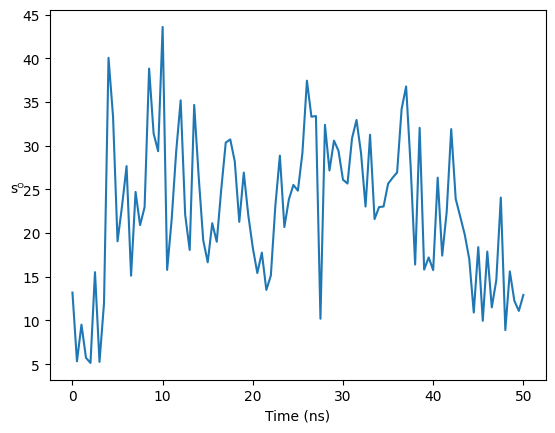

In [31]:
time = np.linspace(0, 50, 101)
plt.plot(time, sO1)
plt.xlabel("Time (ns)")
plt.ylabel("sᴼ", rotation = 0)
plt.show()

In [32]:
xtc = "view_0_50ns.xtc"
gro = "topol.gro"
u = mda.Universe(gro, xtc)
sH1 = []

r0 = 0.4
p = 12
q = 24
step = 50

for i in range(0, len(u.trajectory) + 1, step):

    print(i)

    na_positions = []
    sol_positions = []

    u.trajectory[i]
    u.atoms.write("frame.gro")

    with open("frame.gro", "r") as f:
        lines = f.readlines()

    for line in lines[2:-1]:
        atom_name = line[10:15].strip()
        x = float(line[20:28].strip())
        y = float(line[28:36].strip())
        z = float(line[36:44].strip())
        if atom_name == "NA":
            na_positions.append([x, y, z])
        if atom_name == "OW":
            sol_positions.append([x, y, z])

    sH1.append(0)

    for j in range(len(na_positions)):
        for k in range(len(sol_positions)):
            rij = np.linalg.norm(np.array(na_positions[j]) - np.array(sol_positions[k]))
            sH1[-1] += (1 - (rij/r0)**p)/(1 - (rij/r0)**q)
    sH1[-1] /= len(na_positions)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000


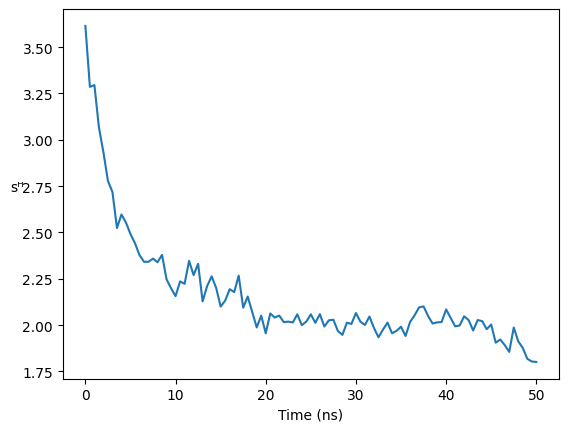

In [33]:
time = np.linspace(0, 50, 101)
plt.plot(time, sH1)
plt.xlabel("Time (ns)")
plt.ylabel("sᴴ", rotation = 0)
plt.show()

In [110]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import connected_components

xtc = "view_0_50ns.xtc"
gro = "topol.gro"
u = mda.Universe(gro, xtc)
ions = u.select_atoms("resname NA CL")

cutoff = 3.5
step = 50
T = 350
kB = 0.008314462618  # kJ/(mol*K)

Fn_blocks = []
block_max_sizes = []
block_centers = []

for i in range(0, len(u.trajectory), step):

    print(i)

    end = min(i + step, len(u.trajectory))
    block_largest = []

    for i in range(i, end):

        u.trajectory[i]
        positions = ions.positions

        if len(positions) == 0:
            block_largest.append(0)
            continue

        dists = squareform(pdist(positions))
        adjacency = (dists < cutoff).astype(int)

        n_clusters, labels = connected_components(adjacency, directed=False)
        unique, counts = np.unique(labels, return_counts=True)
        block_largest.append(max(counts))

    block_largest = np.array(block_largest, dtype=int)
    block_nonzero = block_largest[block_largest > 0]
    if len(block_nonzero) == 0:
        continue

    unique_n, counts = np.unique(block_nonzero, return_counts=True)
    Pn = counts / counts.sum()
    Fn = -kB*T*np.log(Pn)
    Fn -= Fn.min()

    Fn_blocks.append((unique_n, Fn))
    block_max_sizes.append(block_largest.max())
    block_centers.append(i + step//2)

Fn1_time = []
for n_vals, Fn in Fn_blocks:
    max_index = np.argmax(n_vals)
    Fn1_time.append(Fn[max_index])

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000


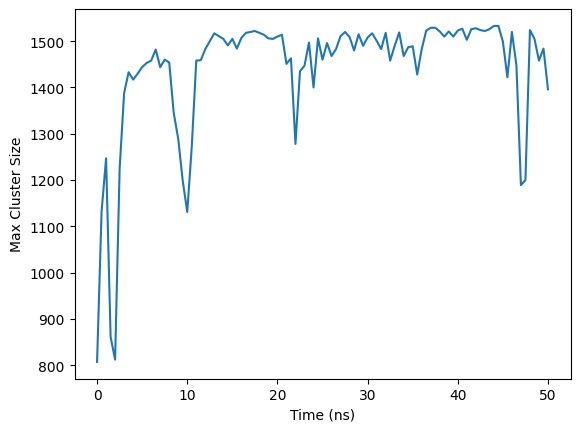

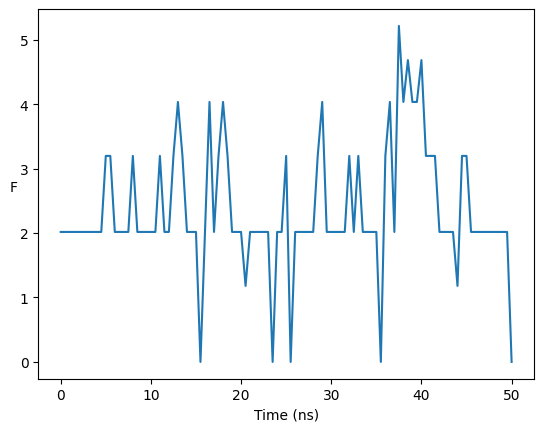

In [111]:
time = np.linspace(0, 50, 101)

plt.plot(time, block_max_sizes)
plt.xlabel("Time (ns)")
plt.ylabel("Max Cluster Size")
plt.show()

plt.plot(time, Fn1_time)
plt.xlabel("Time (ns)")
plt.ylabel("F", rotation = 0)
plt.show()

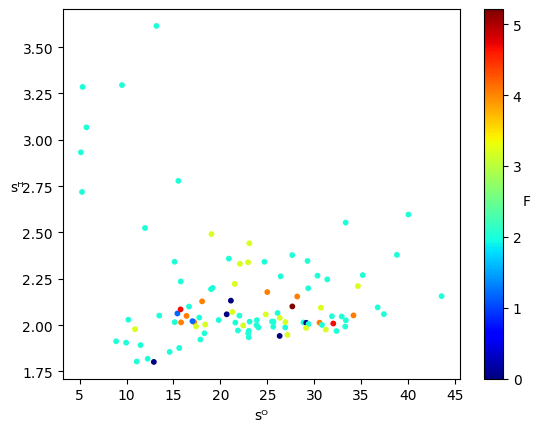

In [114]:
sc = plt.scatter(sO1, sH1, c = Fn1_time, cmap = "jet", s = 10)
cbar = plt.colorbar(sc)
cbar.set_label("F", rotation = 0)
plt.xlabel("sᴼ")
plt.ylabel("sᴴ", rotation = 0)
plt.show()

# 30-Ion Seed

In [34]:
xtc = "cmumd_shell_50ns.xtc"
gro = "cmumd_shell_50ns.gro"
u = mda.Universe(gro, xtc)
sO2 = []

sigma = 0.08
p = 12
q = 24
k0 = 0.5
step = 50

for i in range(0, len(u.trajectory) + 1, step):

    na_positions = []
    cl_positions = []

    u.trajectory[i]
    u.atoms.write("frame.gro")

    with open("frame.gro", "r") as f:
        lines = f.readlines()

    for line in lines[2:-1]:
        atom_name = line[10:15].strip()
        x = float(line[20:28].strip())
        y = float(line[28:36].strip())
        z = float(line[36:44].strip())
        if atom_name == "NA":
            na_positions.append([x, y, z])
        if atom_name == "CL":
            cl_positions.append([x, y, z])

    chi0 = ideal_neighbors(6)
    sO2.append(0)

    for j in range(len(na_positions)):
        ri = np.linalg.norm(np.array(na_positions[j]) - np.array([3, 3, 3]))
        chi = actual_neighbors(np.array(na_positions[j]), np.array(cl_positions), 18)
        kbar = 0
        for k in range(len(chi0)):
            for l in range(len(chi)):
                kbar += np.exp(-((np.linalg.norm(chi0[k] - chi[l]))**2)/(4*sigma**2))
        kbar /= len(chi0)
        sO2[-1] += (1 - (1 - (kbar/k0)**p)/(1 - (kbar/k0)**q))*switch(ri, 1.5, 1.6)

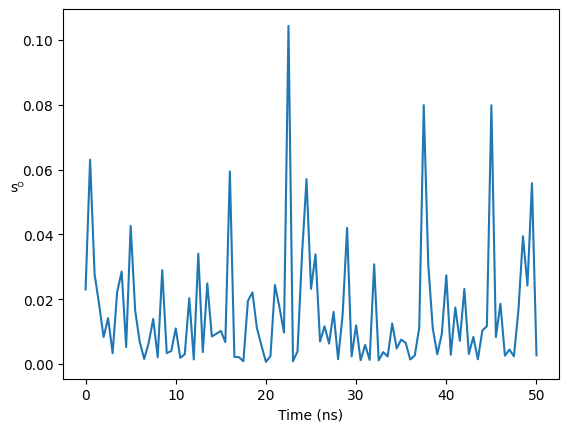

In [35]:
time = np.linspace(0, 50, 101)
plt.plot(time, sO2)
plt.xlabel("Time (ns)")
plt.ylabel("sᴼ", rotation = 0)
plt.show()

In [38]:
xtc = "cmumd_shell_50ns.xtc"
gro = "cmumd_shell_50ns.gro"
u = mda.Universe(gro, xtc)
sH2 = []

r0 = 0.4
step = 50

for i in range(0, len(u.trajectory) + 1, step):

    print(i)

    na_positions = []
    sol_positions = []

    u.trajectory[i]
    u.atoms.write("frame.gro")

    with open("frame.gro", "r") as f:
        lines = f.readlines()

    for line in lines[2:-1]:
        atom_name = line[10:15].strip()
        x = float(line[20:28].strip())
        y = float(line[28:36].strip())
        z = float(line[36:44].strip())
        if atom_name == "NA":
            na_positions.append([x, y, z])
        if atom_name == "OW":
            sol_positions.append([x, y, z])

    sH2.append(0)
    omega = 0

    for j in range(len(na_positions)):
        ri = np.linalg.norm(np.array(na_positions[j]) - np.array([3, 3, 3]))
        omega += switch(ri, 1.5, 1.6)
        for k in range(len(sol_positions)):
            rij = np.linalg.norm(np.array(na_positions[j]) - np.array(sol_positions[k]))
            sH2[-1] += (1 - (rij/r0)**p)/(1 - (rij/r0)**q)*switch(ri, 1.5, 1.6)
    sH2[-1] /= omega

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000


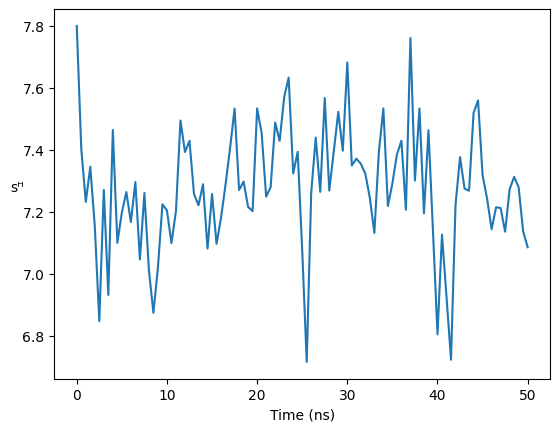

In [39]:
time = np.linspace(0, 50, 101)
plt.plot(time, sH2)
plt.xlabel("Time (ns)")
plt.ylabel("sᴴ", rotation = 0)
plt.show()

In [115]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import connected_components

xtc = "cmumd_shell_50ns.xtc"
gro = "cmumd_shell_50ns.gro"
u = mda.Universe(gro, xtc)
ions = u.select_atoms("resname NA CL")

cutoff = 3.5
step = 50
T = 350
kB = 0.008314462618  # kJ/(mol*K)

Fn_blocks = []
block_max_sizes = []
block_centers = []

for i in range(0, len(u.trajectory), step):

    print(i)

    end = min(i + step, len(u.trajectory))
    block_largest = []

    for i in range(i, end):

        u.trajectory[i]
        positions = ions.positions

        if len(positions) == 0:
            block_largest.append(0)
            continue

        dists = squareform(pdist(positions))
        adjacency = (dists < cutoff).astype(int)

        n_clusters, labels = connected_components(adjacency, directed=False)
        unique, counts = np.unique(labels, return_counts=True)
        block_largest.append(max(counts))

    block_largest = np.array(block_largest, dtype=int)
    block_nonzero = block_largest[block_largest > 0]
    if len(block_nonzero) == 0:
        continue

    unique_n, counts = np.unique(block_nonzero, return_counts=True)
    Pn = counts / counts.sum()
    Fn = -kB*T*np.log(Pn)
    Fn -= Fn.min()

    Fn_blocks.append((unique_n, Fn))
    block_max_sizes.append(block_largest.max())
    block_centers.append(i + step//2)

Fn2_time = []
for n_vals, Fn in Fn_blocks:
    max_index = np.argmax(n_vals)
    Fn2_time.append(Fn[max_index])

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000


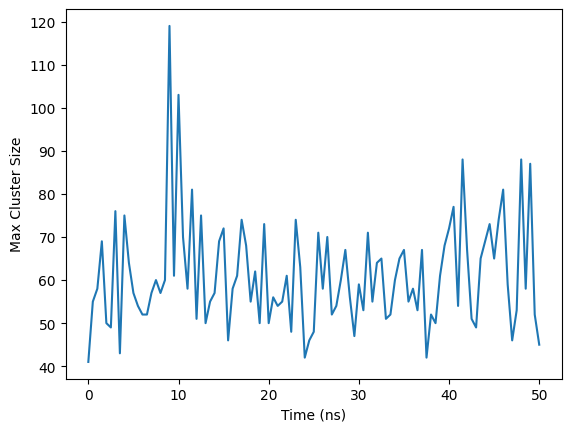

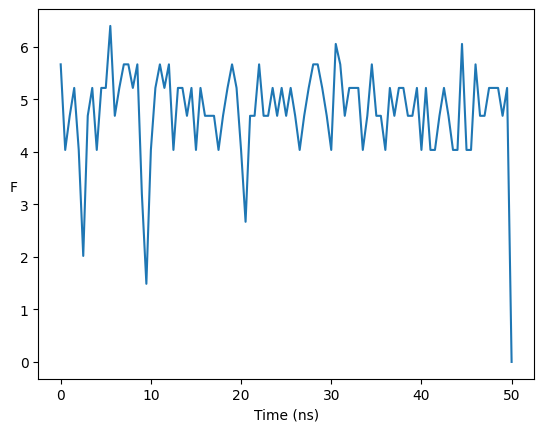

In [116]:
time = np.linspace(0, 50, 101)

plt.plot(time, block_max_sizes)
plt.xlabel("Time (ns)")
plt.ylabel("Max Cluster Size")
plt.show()

plt.plot(time, Fn2_time)
plt.xlabel("Time (ns)")
plt.ylabel("F", rotation = 0)
plt.show()

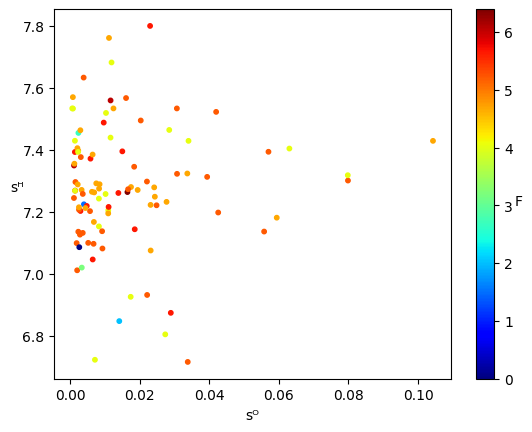

In [117]:
sc = plt.scatter(sO2, sH2, c = Fn2_time, cmap = "jet", s = 10)
cbar = plt.colorbar(sc)
cbar.set_label("F", rotation = 0)
plt.xlabel("sᴼ")
plt.ylabel("sᴴ", rotation = 0)
plt.show()